# Background

The shape of outputs in integrated gradients suggests that IG may overestimate some attribution values due to saturated gradients at interpolated inputs. To confirm this, we run SplitIG (which cuts off the interpolated inputs if the gradients are saturated) and examine the level of agreement.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import pandas as pd
import numpy as np

from functools import partial
from typing import Optional

from transformer_lens.utils import get_act_name, get_device
from transformer_lens import ActivationCache, HookedTransformer, HookedTransformerConfig
from transformer_lens.hook_points import HookPoint

import seaborn as sns
import matplotlib.pyplot as plt

from utils import Task, TaskDataset, logit_diff_metric, run_from_layer_fn, plot_attn_comparison, plot_correlation
from split_ig import SplitLayerIntegratedGradients

from captum.attr import LayerIntegratedGradients
from attribution_methods import compute_layer_to_output_attributions, integrated_gradients

/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
torch.set_grad_enabled(False)

device = get_device()
# device = torch.device("cpu")
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

Loaded pretrained model gpt2-small into HookedTransformer


## Set up Split IG

In [45]:
def reshape_fortran(data, shape):
    device = data.device
    data = np.reshape(data.detach().cpu().numpy(), shape, order='F')
    return torch.tensor(data).to(device)

def compute_layer_to_output_attributions_split_ig(
    original_input, 
    layer_input, 
    layer_baseline, 
    target_layer, 
    prev_layer, 
    metric, 
    metric_labels, 
    ratio=1.0,
):
    n_steps = 50
    n_samples = original_input.size(0)

    # Take the model starting from the target layer
    forward_fn = lambda x: run_from_layer_fn(model, original_input, prev_layer, x, metric, metric_labels)

    # Attribute to the target_layer's output
    split_ig = SplitLayerIntegratedGradients(forward_fn, target_layer, multiply_by_inputs=True)
    attributions = split_ig.attribute(inputs=layer_input,
                                    baselines=layer_baseline,
                                    n_steps=n_steps,
                                    internal_batch_size=n_samples, # Needs to match patching shape
                                    attribute_to_layer_input=False,
                                    return_convergence_delta=False)
    grads, outputs, _, _ = attributions

    # [n_samples, n_steps, seq_len, d_heads, d_model]
    grads_shape = (n_samples, n_steps,) + grads.shape[1:]
    grads = reshape_fortran(grads, grads_shape)
    outputs = reshape_fortran(outputs, (n_samples, n_steps))

    # Sanity check: shape of output
    # plt.plot(outputs[0].detach().cpu())
    # plt.show()

    left_igs = torch.zeros((n_samples,) + grads.shape[2:])
    right_igs = torch.zeros((n_samples,)+ grads.shape[2:])
    threshold_indices = torch.zeros((n_samples,))

    for i in range(n_samples):
        sample_output = outputs[i] # Shape [n_steps]
        sample_grads = grads[i] # Shape [n_steps, seq_len, d_heads, d_model]

        # Calculate threshold for split integrated gradients
        min_out, min_index = torch.min(sample_output, dim=0)
        max_out, max_index = torch.max(sample_output, dim=0)
        # Take output values up until threshold
        threshold = min_out + ratio * (max_out - min_out)

        if ratio == 1:
            assert torch.isclose(threshold, max_out), f"Threshold {threshold} is not equal to maximum {max_out} at {max_index}, when minimum is {min_out} at {min_index}"

        if max_index < min_index:
            # Flip direction such that min_index < max_index
            sample_output = sample_output.flip(dims=(0,))
            sample_grads = sample_grads.flip(dims=(0,))

        mask = sample_output > threshold + 1e-5 # Handle float precision errors
        if torch.count_nonzero(mask) > 0:
            print(f"There are outputs above the threshold {threshold}. {mask}")
            threshold_index = mask.int().argmax(dim=0)
            print(f"Value at threshold index: {sample_output[threshold_index]}")
            if max_index < min_index:
                threshold_indices[i] = n_steps - threshold_index
            else:
                threshold_indices[i] = threshold_index
        else:
            # No value is above threshold, take full IG
            threshold_index = n_steps
            threshold_indices[i] = threshold_index

        if ratio == 1:
            assert threshold_indices[i] == n_steps, f"Threshold index is {threshold_indices[i]}, expected {n_steps}."

        # Grads have already been scaled and multiplied.
        left_igs[i] = sample_grads[:threshold_index].sum(dim=0)
        right_igs[i] = sample_grads[threshold_index:].sum(dim=0)

    return left_igs, right_igs, threshold_indices

In [37]:
def split_integrated_gradients(model: HookedTransformer, clean_tokens: torch.Tensor, clean_cache: ActivationCache, corrupted_cache: ActivationCache, metric: callable, metric_labels, ratio: float):
    n_samples = clean_tokens.size(0)
    
    # Gradient attribution for neurons in MLP layers
    mlp_results = torch.zeros(n_samples, model.cfg.n_layers, model.cfg.d_mlp)
    # Gradient attribution for attention heads
    attn_results = torch.zeros(n_samples, model.cfg.n_layers, model.cfg.n_heads)

    # Calculate integrated gradients for each layer
    for layer in range(model.cfg.n_layers):

        # Gradient attribution on heads
        hook_name = get_act_name("result", layer)
        target_layer = model.hook_dict[hook_name]
        prev_layer_hook = get_act_name("z", layer)
        prev_layer = model.hook_dict[prev_layer_hook]

        layer_clean_input = clean_cache[prev_layer_hook]
        layer_corrupt_input = corrupted_cache[prev_layer_hook]

        # Shape [batch, seq_len, d_head, d_model]
        left_ig, right_ig, _ = compute_layer_to_output_attributions_split_ig(
            clean_tokens, layer_corrupt_input, layer_clean_input, target_layer, prev_layer, metric, metric_labels, ratio)

        # Calculate attribution score based on mean over each embedding, for each token
        per_token_score = left_ig.mean(dim=3)
        score = per_token_score.mean(dim=1)
        attn_results[:, layer] = score

        # Gradient attribution on MLP neurons
        hook_name = get_act_name("post", layer)
        target_layer = model.hook_dict[hook_name]
        prev_layer_hook = get_act_name("mlp_in", layer)
        prev_layer = model.hook_dict[prev_layer_hook]

        layer_clean_input = clean_cache[prev_layer_hook]
        layer_corrupt_input = corrupted_cache[prev_layer_hook]
        
        # Shape [batch, seq_len, d_model]
        left_ig, right_ig, _ = compute_layer_to_output_attributions_split_ig(
            clean_tokens, layer_corrupt_input, layer_clean_input, target_layer, prev_layer, metric, metric_labels, ratio)
        score = left_ig.mean(dim=1)
        mlp_results[:, layer] = score

    return mlp_results, attn_results

# Split IG and IOI

In [38]:
ioi_dataset = TaskDataset(Task.IOI)
ioi_dataloader = ioi_dataset.to_dataloader(batch_size=10)

In [39]:
clean_input, corrupted_input, labels = next(iter(ioi_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([-0.0307, -0.9269, -0.4937,  2.2320,  0.6754,  4.0447, -0.1785,  1.1947,
         1.1514,  1.7507], device='cuda:0')
Corrupted logit difference: tensor([-0.0387, -0.9451, -0.5103,  2.2153,  0.6299, -3.2074, -0.1823,  1.1766,
        -3.0072,  1.7392], device='cuda:0')


## Sanity check: no splitting

In [46]:
# Check that attention head attributions are the same for random head

hook_name = get_act_name("result", 5)
target_layer = model.hook_dict[hook_name]
prev_layer_hook = get_act_name("z", 5)
prev_layer = model.hook_dict[prev_layer_hook]

layer_clean_input = clean_cache[prev_layer_hook]
layer_corrupt_input = corrupted_cache[prev_layer_hook]

# Shape [batch, seq_len, d_head, d_model]
left_ig, _, _ = compute_layer_to_output_attributions_split_ig(
    clean_tokens, layer_corrupt_input, layer_clean_input, target_layer, prev_layer, logit_diff_metric, labels, ratio=1)

original_attributions = compute_layer_to_output_attributions(
    model, clean_tokens, layer_corrupt_input, layer_clean_input, target_layer, prev_layer, logit_diff_metric, labels
)


Error (delta) for blocks.5.attn.hook_result attribution: tensor([ 8.3819e-09, -9.2387e-07, -4.4703e-08,  3.6322e-07,  1.6876e-06,
        -1.0312e-05, -7.9907e-07,  1.4901e-06, -2.3842e-06, -1.0030e-06],
       device='cuda:0')


In [47]:
print(left_ig[0, :, 5])
print(original_attributions[0, :, 5])

torch.allclose(left_ig, original_attributions.detach().cpu())

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 1.0874e-07, -1.9514e-07,  3.9911e-07,  ..., -2.1522e-07,
          1.5323e-08,  3.7825e-08],
        [ 2.0432e-07, -2.5469e-07,  2.2541e-07,  ..., -3.7143e-07,
         -8.9805e-08,  1.8190e-10],
        [ 3.7631e-06,  1.7639e-07,  1.9599e-07,  ..., -4.3301e-06,
         -2.8954e-06,  2.9951e-06]])
tensor([[ 0.0000e+00,  0.0000e+00, -0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00, -0.0000e+00],
        [ 0.0000e+00, -0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         -0.0000e+00,  0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 1.0874e-07, -1.9514e-07,  3.9911e-07

True

In [34]:
n_samples = clean_tokens.size(0)
forward_fn = lambda x: run_from_layer_fn(model, clean_tokens, prev_layer, x, logit_diff_metric, labels)

split_ig = SplitLayerIntegratedGradients(forward_fn, target_layer, multiply_by_inputs=True)
split_ig_attributions, _, _, interpolated_inputs = split_ig.attribute(inputs=layer_corrupt_input,
                                baselines=layer_clean_input,
                                internal_batch_size=n_samples, # Needs to match patching shape
                                attribute_to_layer_input=False,
                                return_convergence_delta=False)
# split_ig_attributions = split_ig_attributions.reshape((n_samples, 50,) + split_ig_attributions.shape[1:])
split_ig_attributions = np.reshape(split_ig_attributions.detach().cpu().numpy(), (n_samples, 50,) + split_ig_attributions.shape[1:], order='F')
split_ig_attributions = torch.tensor(split_ig_attributions).to(device).sum(dim=1)

ig_embed = LayerIntegratedGradients(forward_fn, target_layer, multiply_by_inputs=True)
ig_attributions = ig_embed.attribute(inputs=layer_corrupt_input,
                                baselines=layer_clean_input, 
                                internal_batch_size=n_samples,
                                attribute_to_layer_input=False,
                                return_convergence_delta=False)

In [35]:
print(split_ig_attributions.shape)
print(ig_attributions.shape)

print(split_ig_attributions[0, :, 5])
print(ig_attributions[0, :, 5])

torch.allclose(split_ig_attributions, ig_attributions)

torch.Size([2, 20, 12, 768])
torch.Size([2, 20, 12, 768])
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [-1.7688e-12,  2.1741e-08,  1.3779e-08,  ...,  3.7744e-08,
          3.0907e-08,  7.7766e-08],
        [ 1.3751e-07, -2.4608e-07,  4.9891e-07,  ..., -3.2090e-07,
          2.4322e-08, -2.3103e-08],
        [ 2.9961e-06,  2.2031e-07,  1.5137e-06,  ..., -4.0599e-06,
         -1.4916e-06,  3.0198e-06]], device='cuda:0')
tensor([[ 0.0000e+00,  0.0000e+00, -0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00, -0.0000e+00],
        [ 0.0000e+00, -0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         -0.0000e+00,  0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00

True

In [48]:
ioi_split_ig_mlp, ioi_split_ig_attn = split_integrated_gradients(
    model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels, ratio=1
)

In [49]:
# original_ioi_ig_mlp, original_ioi_ig_attn = integrated_gradients(
#     model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels
# )
original_ioi_ig_mlp = torch.load("saved_results/ioi_ig_mlp.pt")
original_ioi_ig_attn = torch.load("saved_results/ioi_ig_attn.pt")

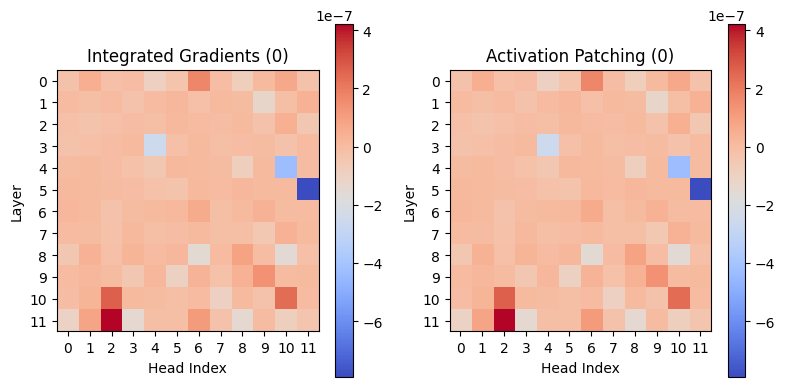

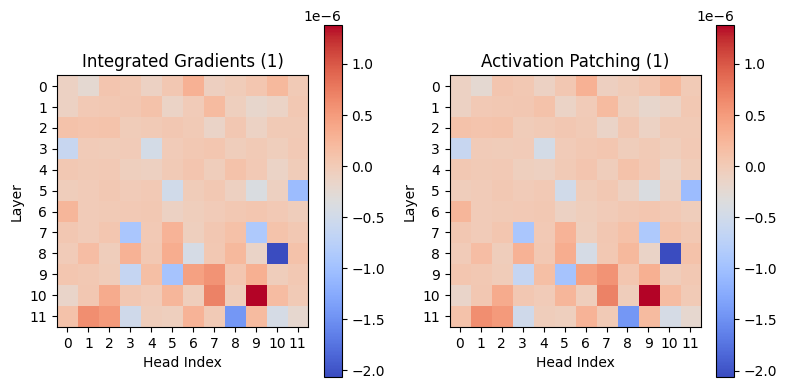

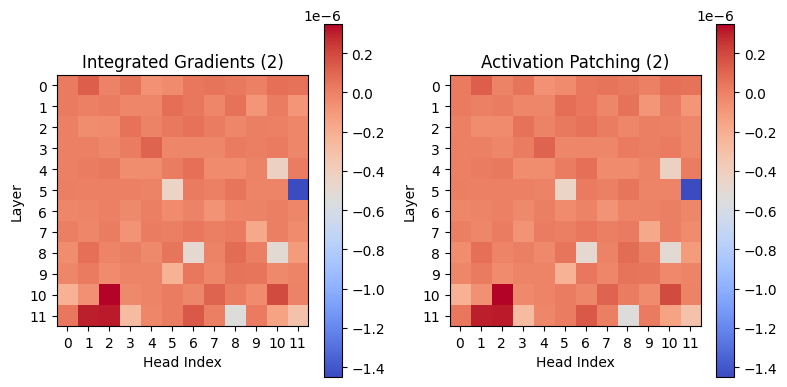

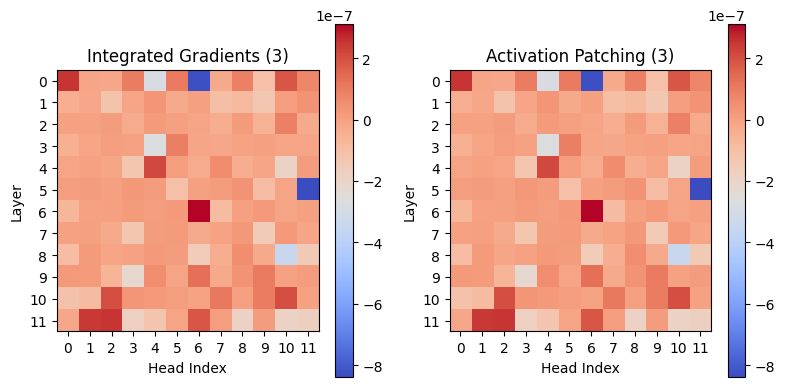

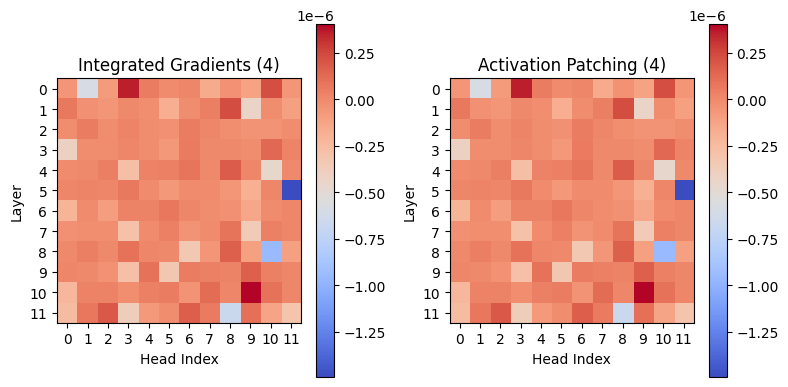

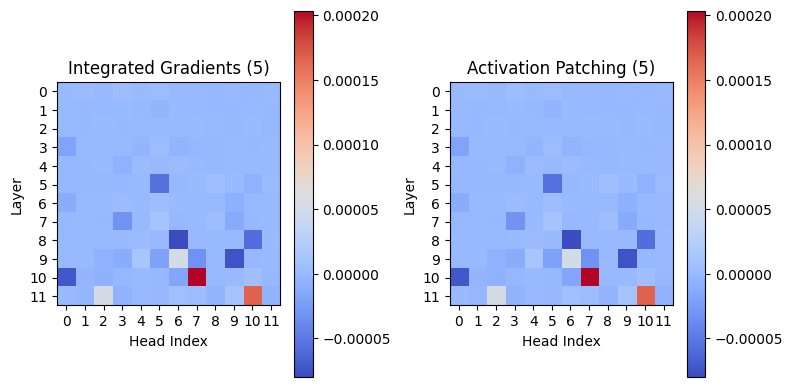

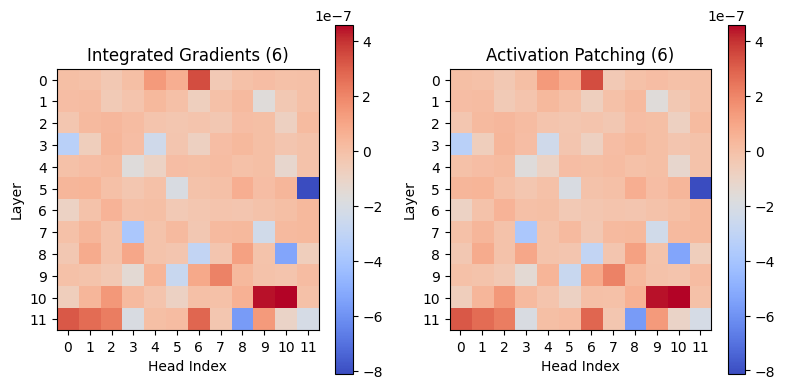

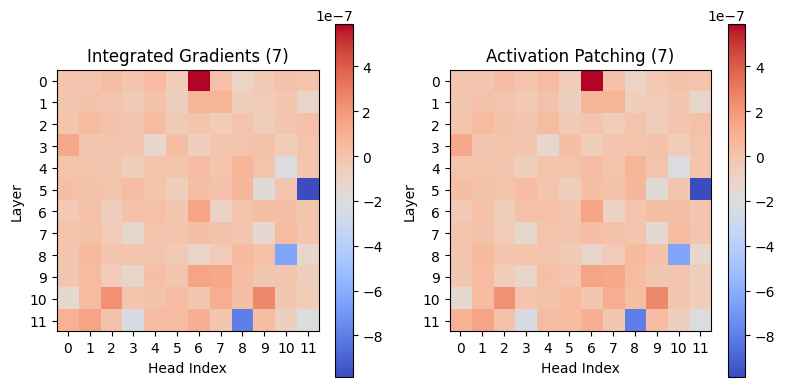

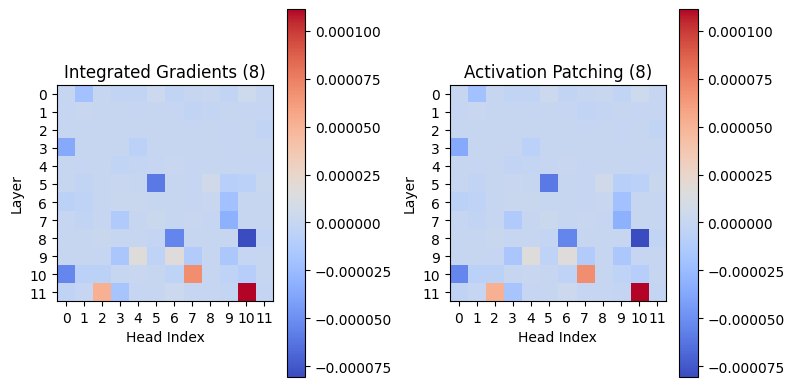

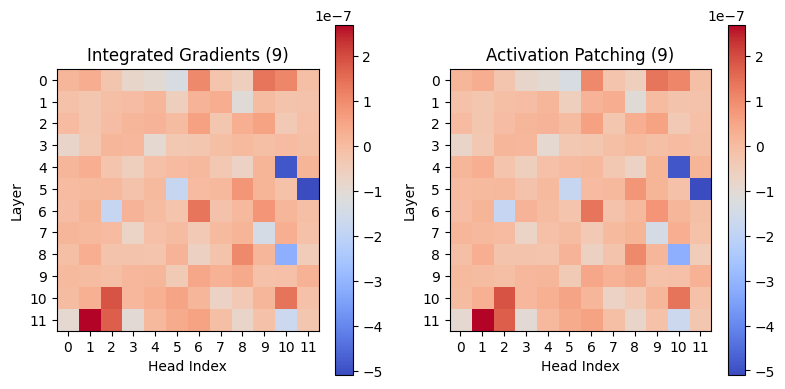

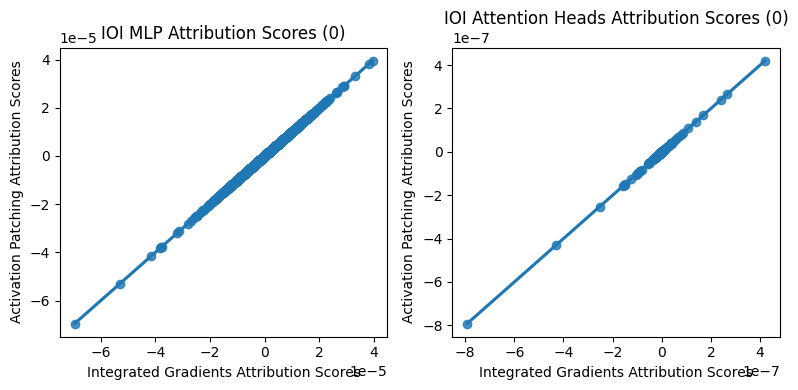

Correlation coefficient for neurons: 0.9999999999999899
Correlation coefficient for attention heads: 0.9999999999999929


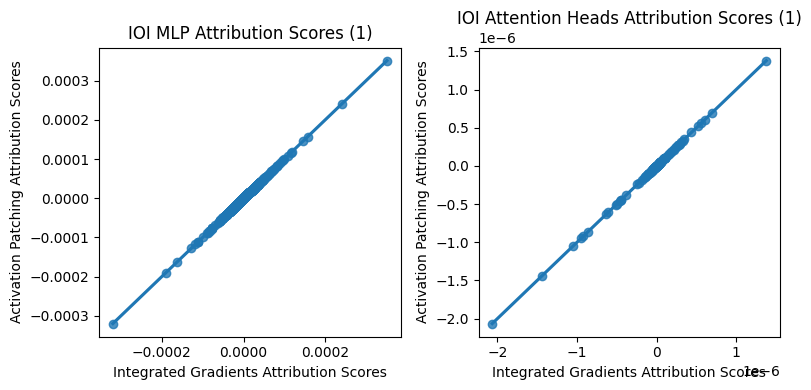

Correlation coefficient for neurons: 0.9999999999999908
Correlation coefficient for attention heads: 0.9999999999999943


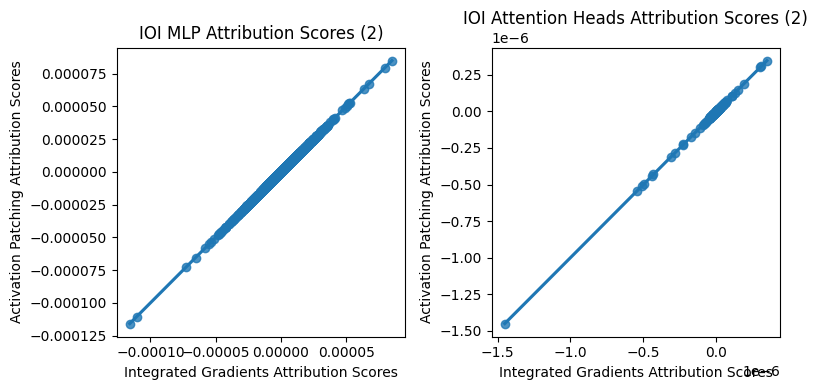

Correlation coefficient for neurons: 0.9999999999999902
Correlation coefficient for attention heads: 0.9999999999999963


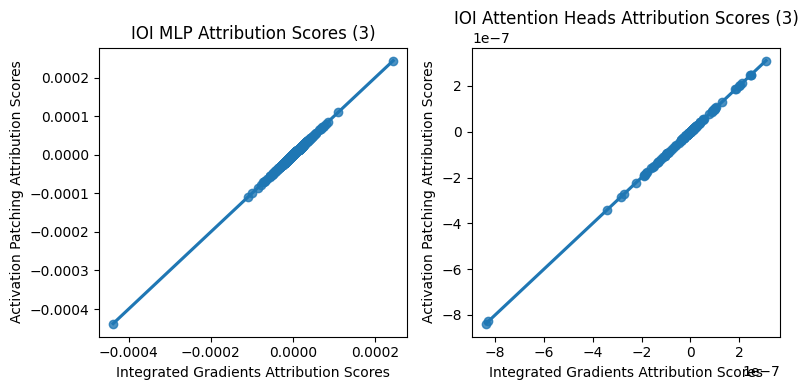

Correlation coefficient for neurons: 0.9999999999999932
Correlation coefficient for attention heads: 0.9999999999999966


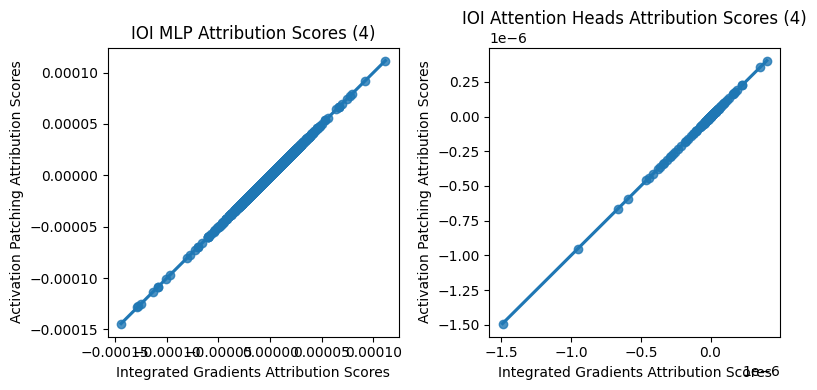

Correlation coefficient for neurons: 0.9999999999999903
Correlation coefficient for attention heads: 0.999999999999991


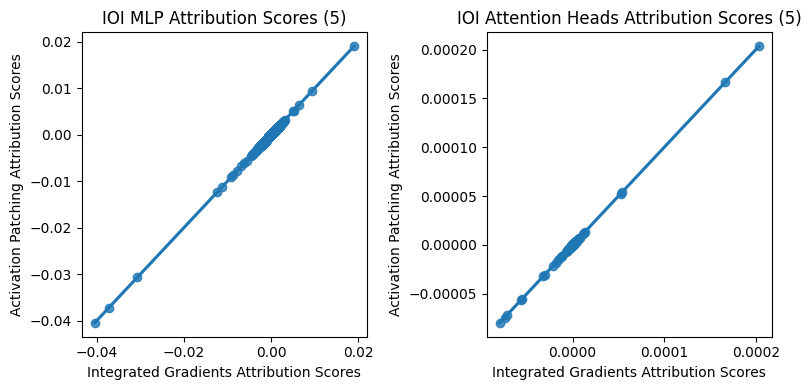

Correlation coefficient for neurons: 0.9999999999999944
Correlation coefficient for attention heads: 0.9999999999999983


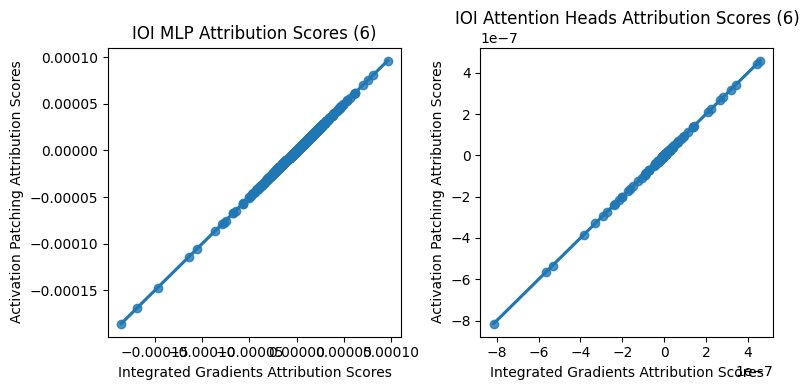

Correlation coefficient for neurons: 0.9999999999999898
Correlation coefficient for attention heads: 0.9999999999999928


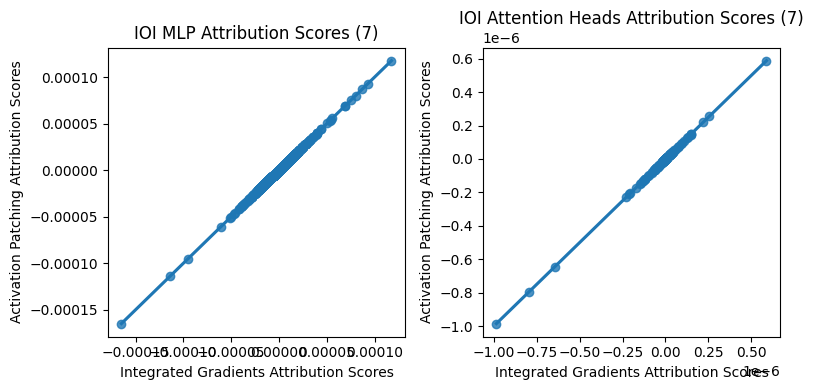

Correlation coefficient for neurons: 0.9999999999999916
Correlation coefficient for attention heads: 0.999999999999994


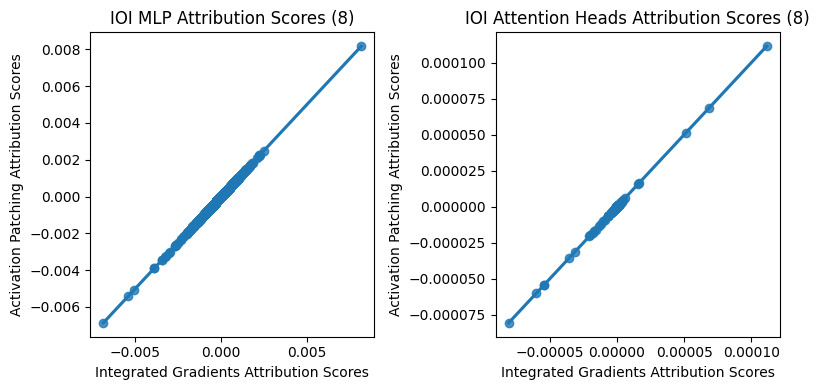

Correlation coefficient for neurons: 0.9999999999999892
Correlation coefficient for attention heads: 0.9999999999999933


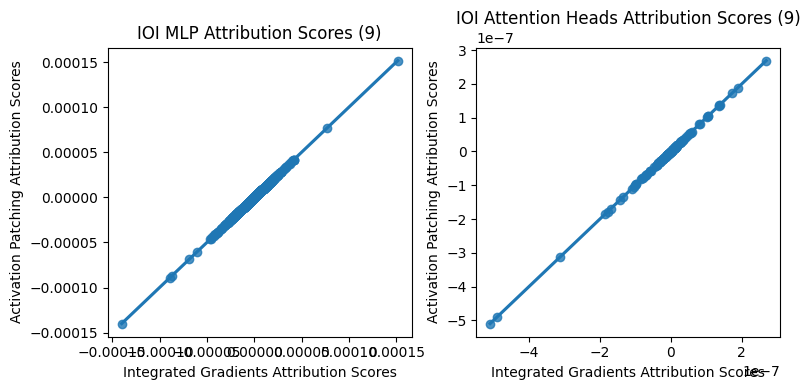

Correlation coefficient for neurons: 0.999999999999991
Correlation coefficient for attention heads: 0.9999999999999867


In [50]:
plot_attn_comparison(ioi_split_ig_attn, original_ioi_ig_attn, Task.IOI, model)
plot_correlation(ioi_split_ig_mlp, original_ioi_ig_mlp, ioi_split_ig_attn, original_ioi_ig_attn, Task.IOI)

## Split at 0.95 ratio

In [51]:
ioi_ap_mlp = torch.load("saved_results/ioi_ap_mlp.pt")
ioi_ap_attn = torch.load("saved_results/ioi_ap_attn.pt")

In [ ]:
ioi_split_ig_mlp = torch.load("saved_results/ioi_split_ig_mlp.pt")
ioi_split_ig_attn = torch.load("saved_results/ioi_split_ig_attn.pt")

SyntaxError: invalid syntax (4235631849.py, line 2)

In [52]:
ioi_split_ig_mlp, ioi_split_ig_attn = split_integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels, ratio=0.95)

torch.save(ioi_split_ig_mlp, "saved_results/ioi_split_ig_mlp.pt")
torch.save(ioi_split_ig_attn, "saved_results/ioi_split_ig_attn.pt")

There are outputs above the threshold -0.03059740737080574. tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True,  True,  True,  True,  True, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False],
       device='cuda:0')
Value at threshold index: -0.030586838722229004
There are outputs above the threshold -0.9248288869857788. tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
Val

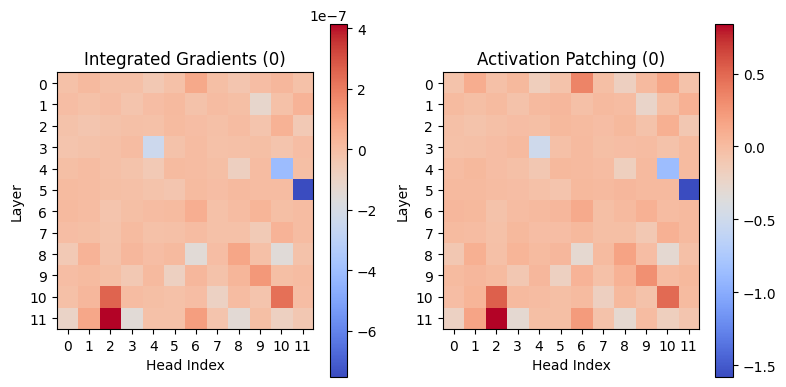

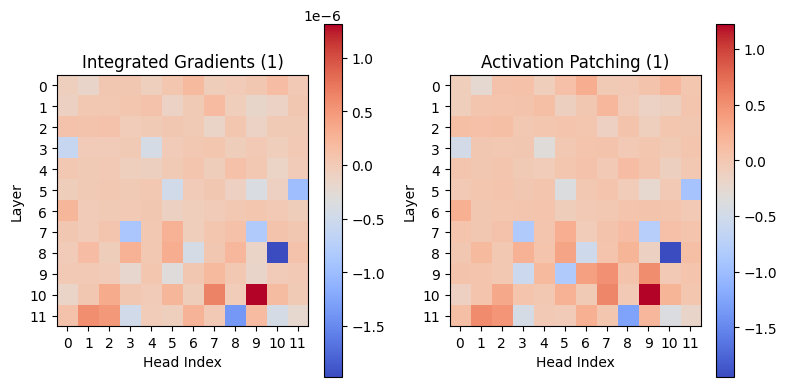

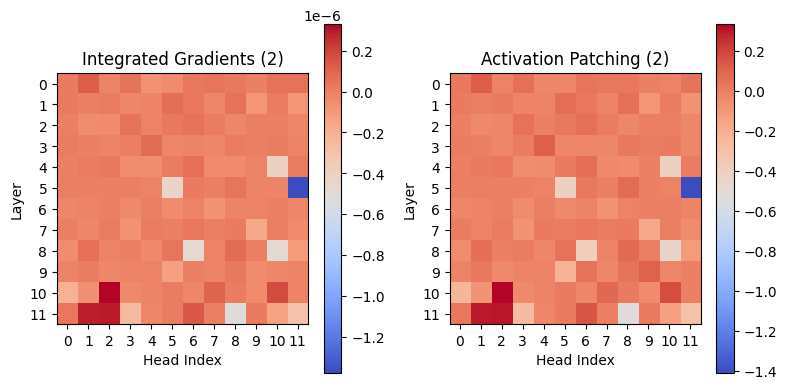

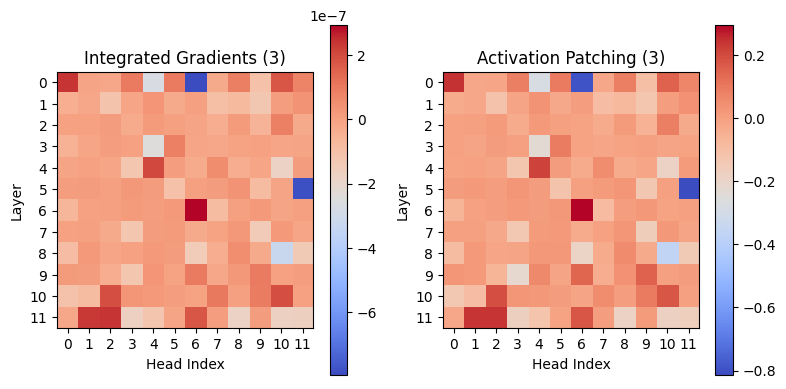

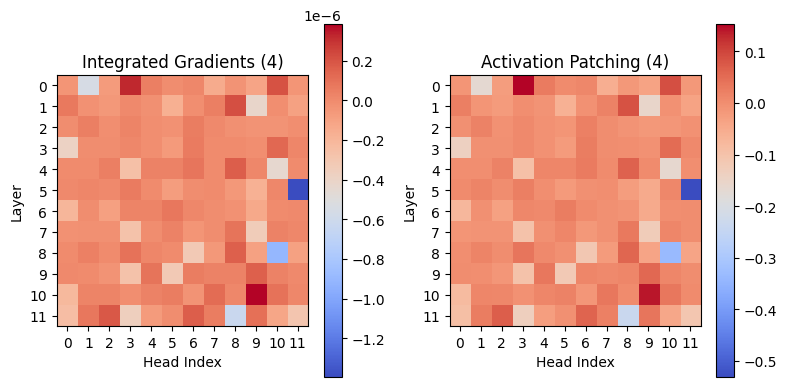

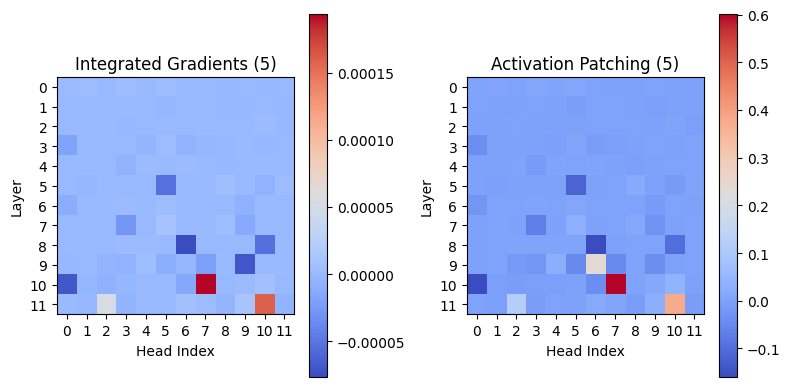

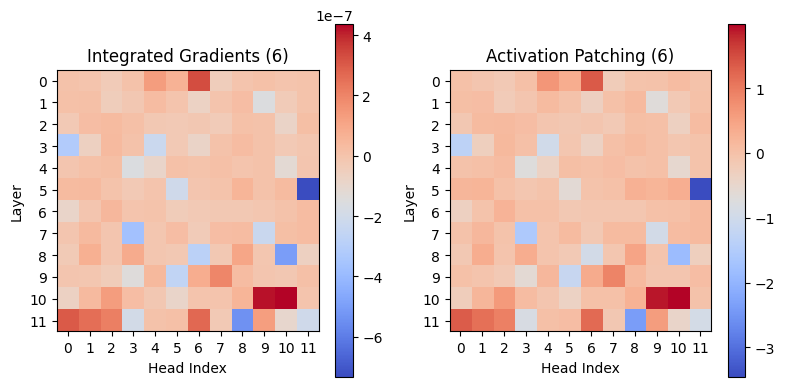

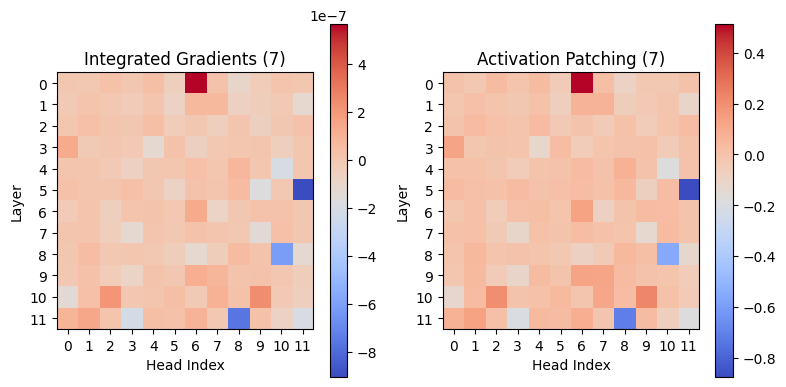

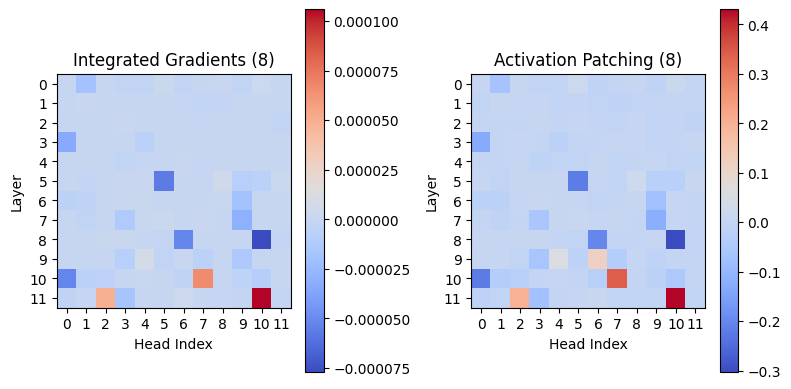

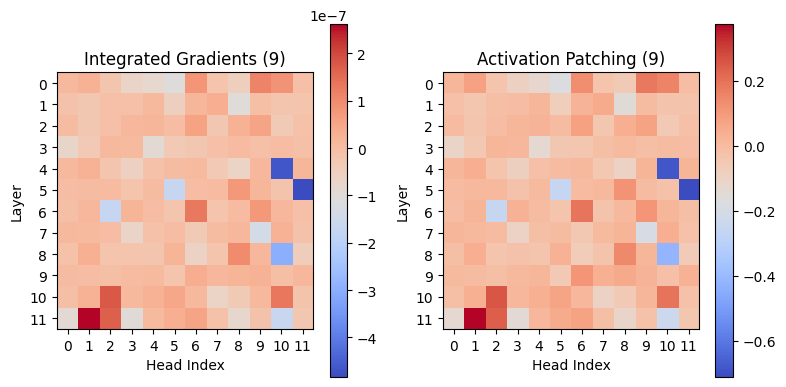

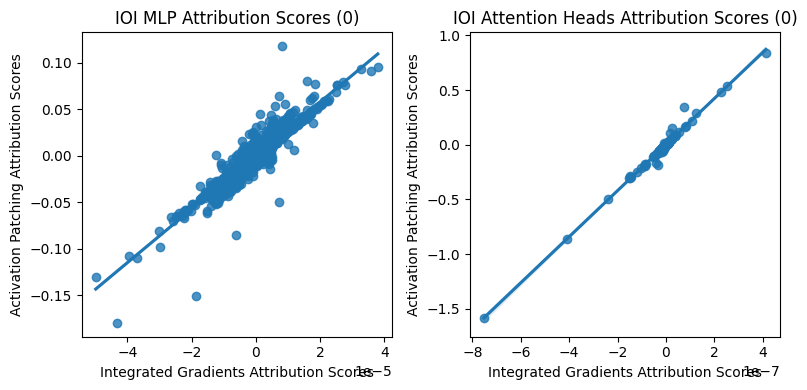

Correlation coefficient for neurons: 0.9611072107751975
Correlation coefficient for attention heads: 0.9929807722989664


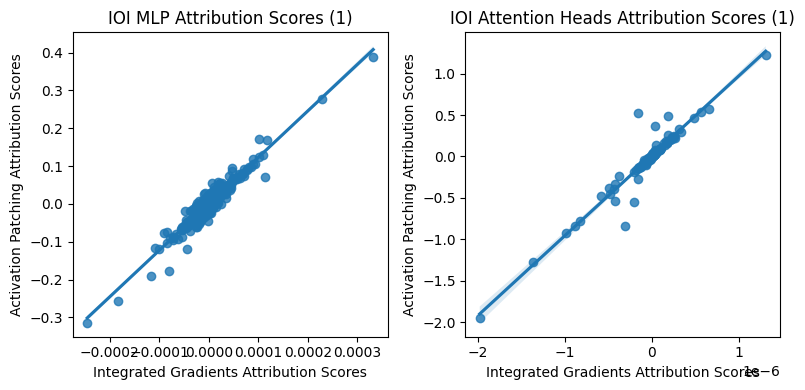

Correlation coefficient for neurons: 0.9678014151199149
Correlation coefficient for attention heads: 0.9560046564816352


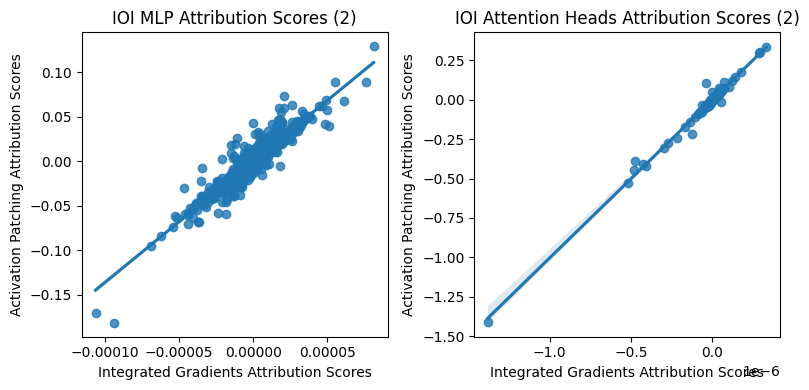

Correlation coefficient for neurons: 0.9624336199020187
Correlation coefficient for attention heads: 0.9923865219835922


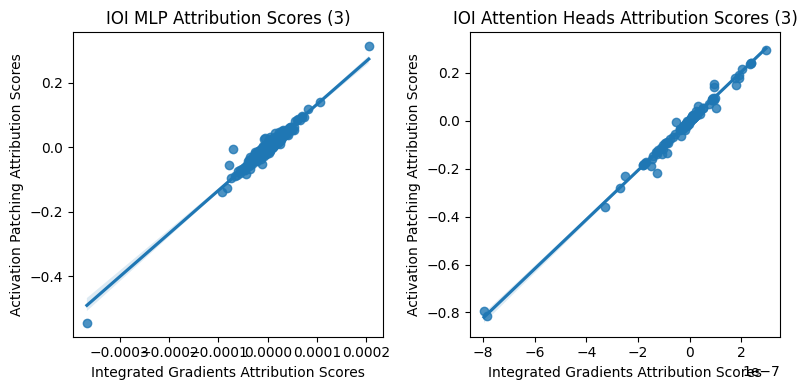

Correlation coefficient for neurons: 0.978164073831036
Correlation coefficient for attention heads: 0.994139530197597


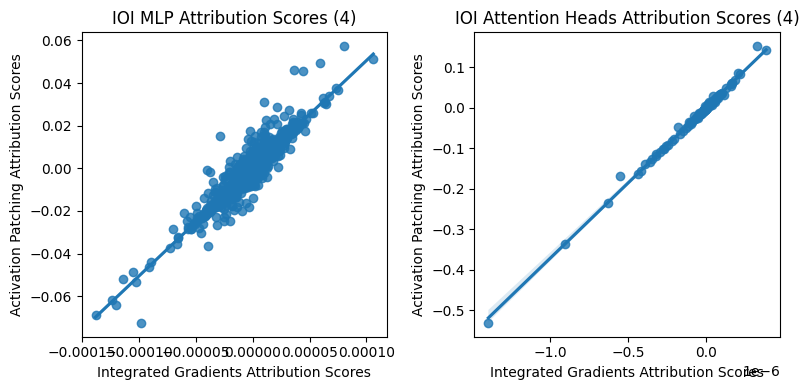

Correlation coefficient for neurons: 0.9599109652188194
Correlation coefficient for attention heads: 0.997555617808682


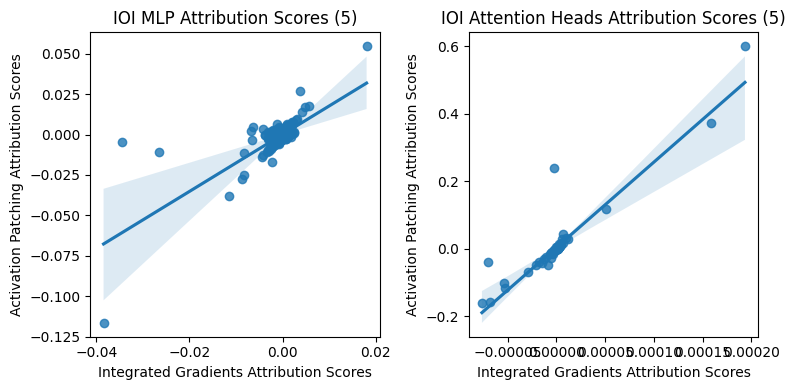

Correlation coefficient for neurons: 0.7373999117726531
Correlation coefficient for attention heads: 0.9261296900747097


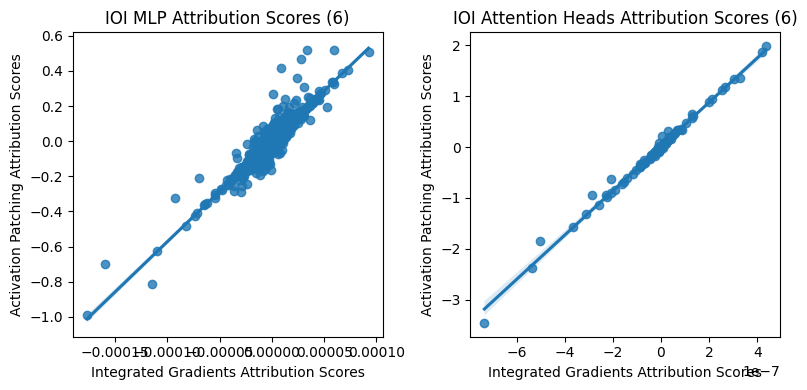

Correlation coefficient for neurons: 0.9611167365880267
Correlation coefficient for attention heads: 0.9953971514448049


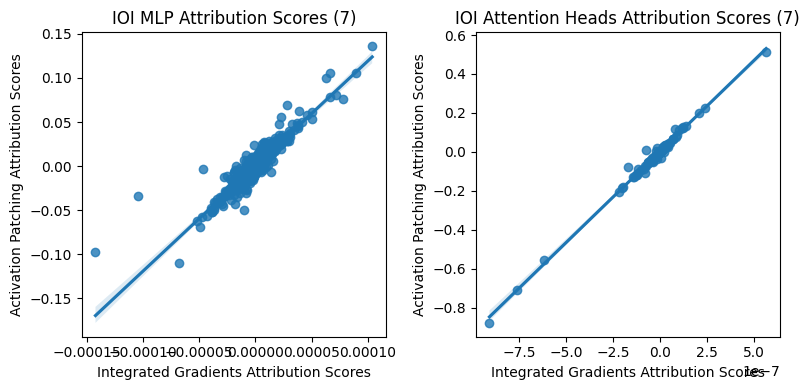

Correlation coefficient for neurons: 0.9558251564713767
Correlation coefficient for attention heads: 0.9946604454336303


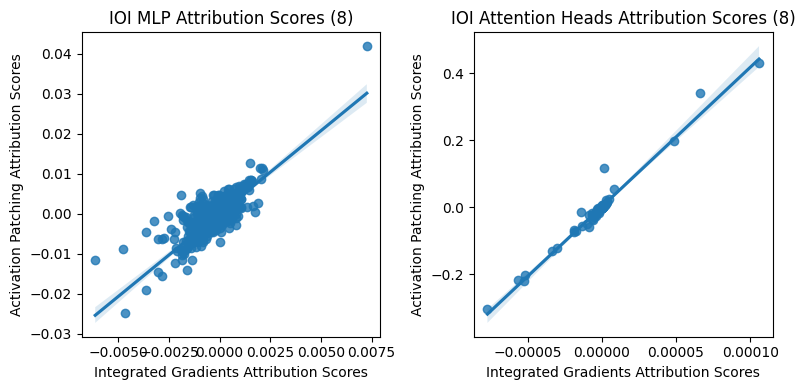

Correlation coefficient for neurons: 0.8409279576096806
Correlation coefficient for attention heads: 0.9835250799625408


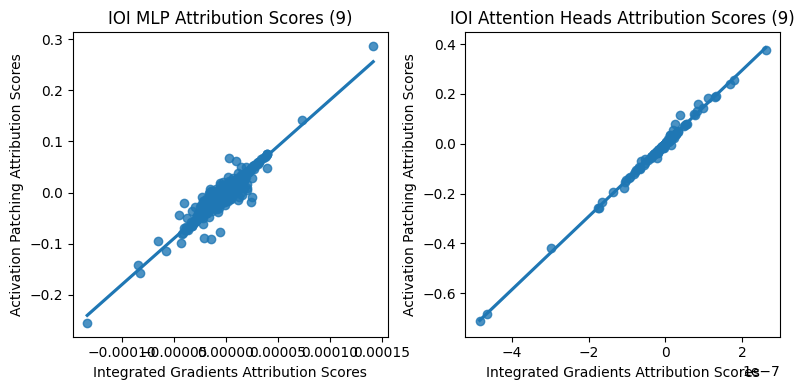

Correlation coefficient for neurons: 0.9654390306343191
Correlation coefficient for attention heads: 0.9972055370127776


In [53]:
plot_attn_comparison(ioi_split_ig_attn, ioi_ap_attn, Task.IOI, model)
plot_correlation(ioi_split_ig_mlp, ioi_ap_mlp, ioi_split_ig_attn, ioi_ap_attn, Task.IOI)

## Split at 0.9 ratio

In [54]:
ioi_split_ig_mlp, ioi_split_ig_attn = split_integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels, ratio=0.90)

There are outputs above the threshold -0.030610715970396996. tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False],
       device='cuda:0')
Value at threshold index: -0.030600547790527344
There are outputs above the threshold -0.9249361753463745. tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
Va

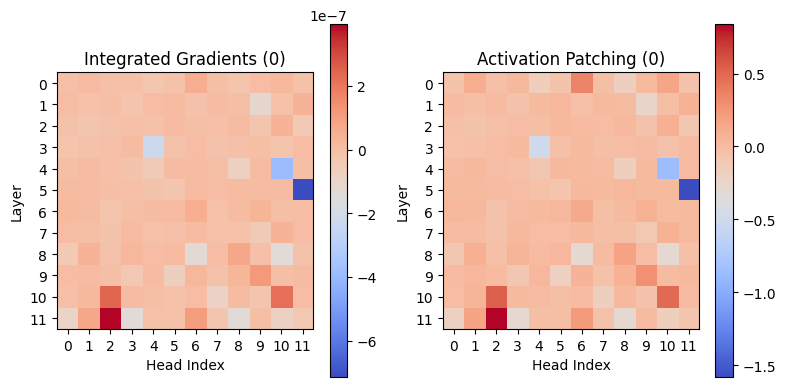

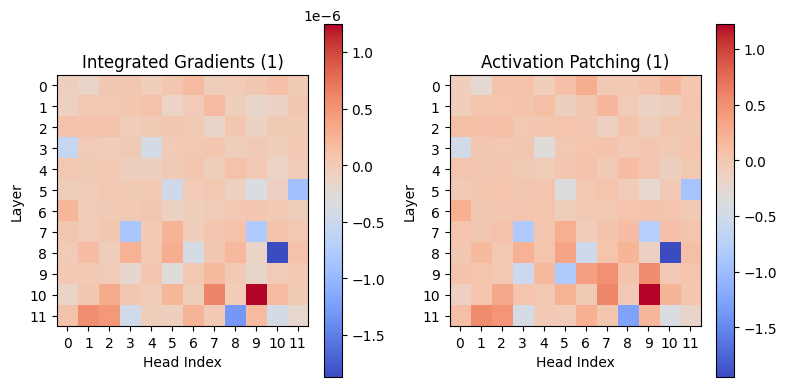

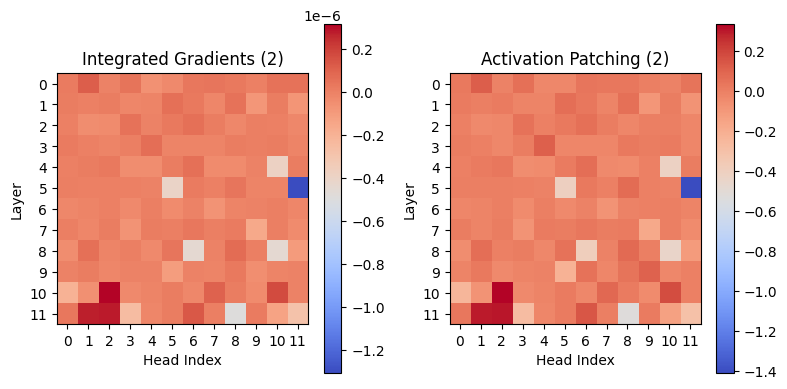

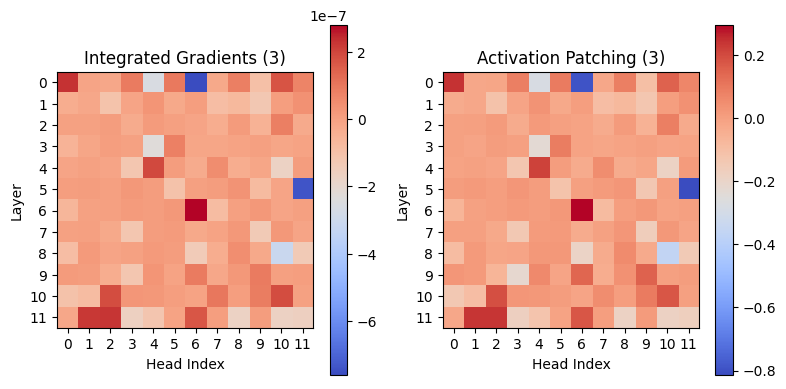

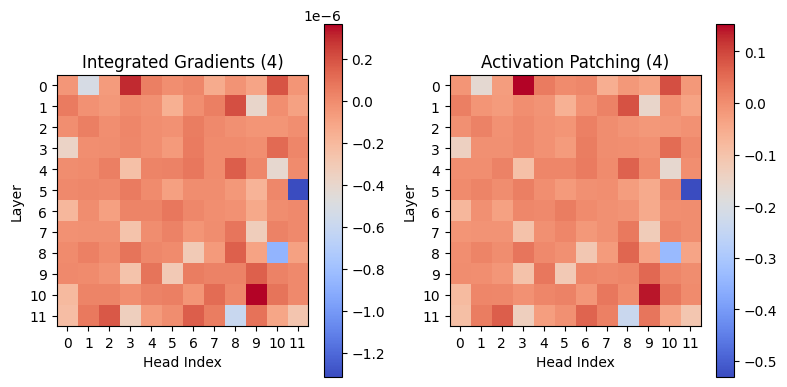

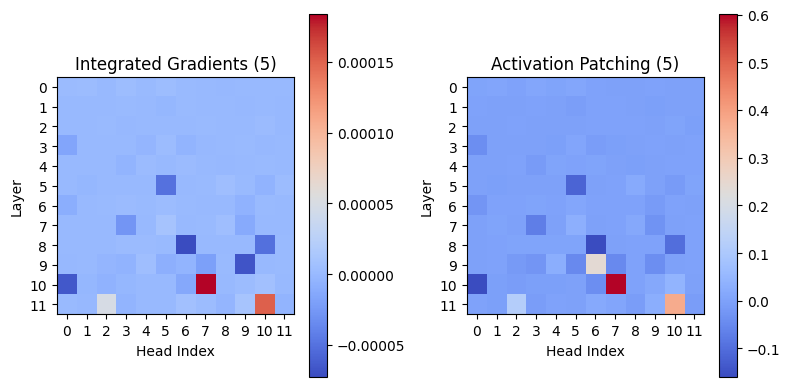

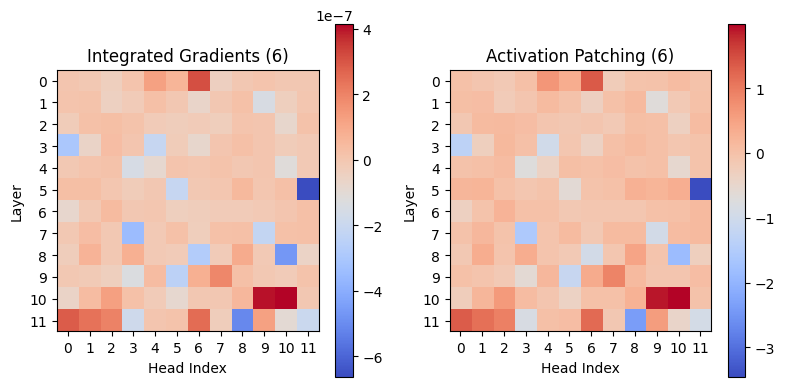

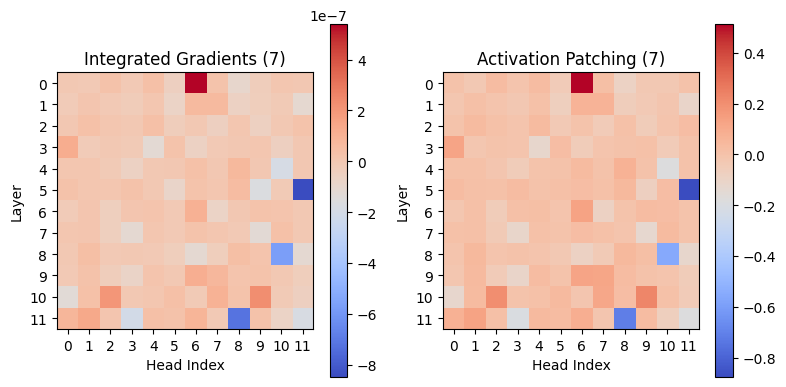

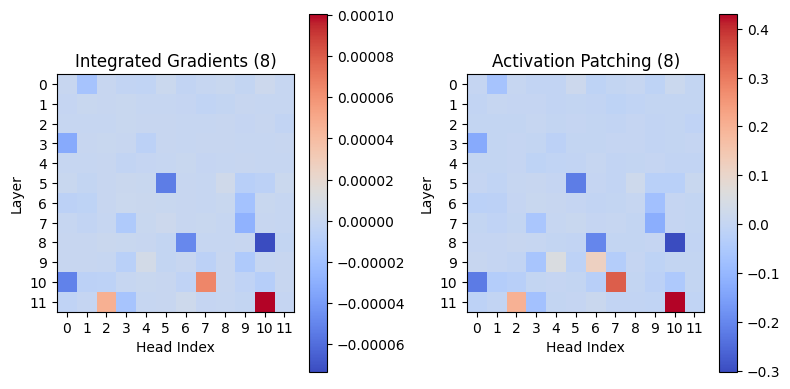

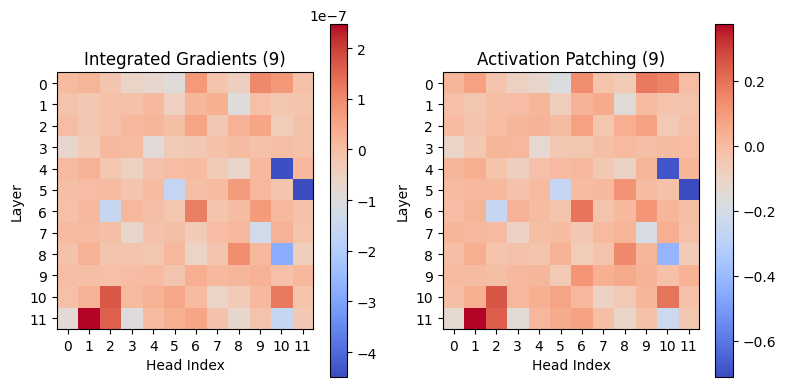

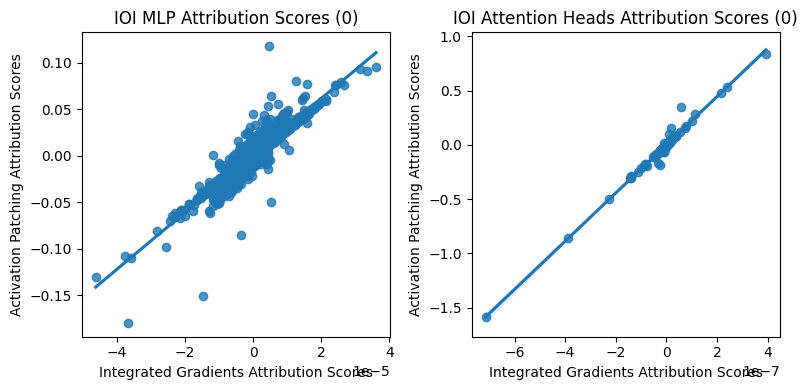

Correlation coefficient for neurons: 0.9516350244090548
Correlation coefficient for attention heads: 0.9910995479619965


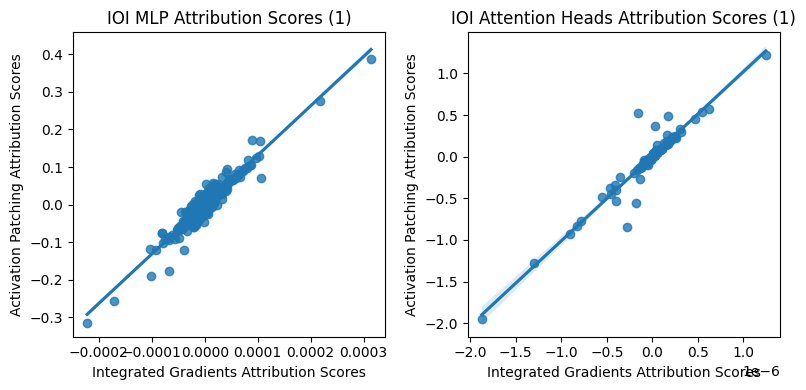

Correlation coefficient for neurons: 0.9635557597665959
Correlation coefficient for attention heads: 0.9542017425426226


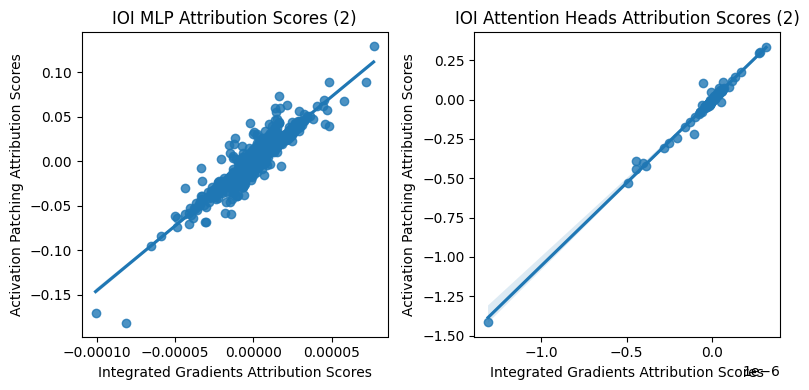

Correlation coefficient for neurons: 0.9544626953383427
Correlation coefficient for attention heads: 0.9912233622598429


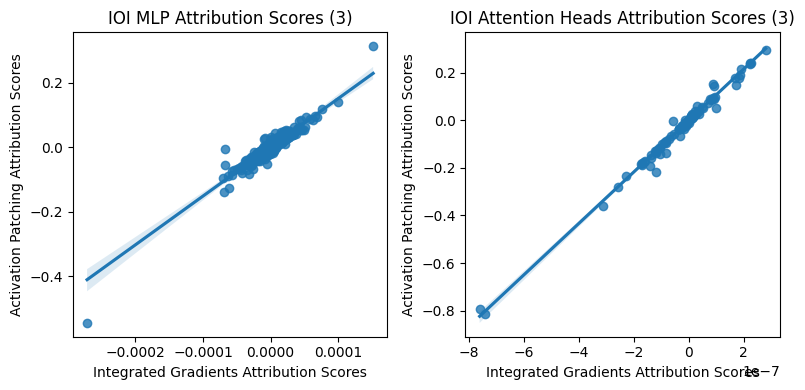

Correlation coefficient for neurons: 0.9596286787040503
Correlation coefficient for attention heads: 0.9938379430659455


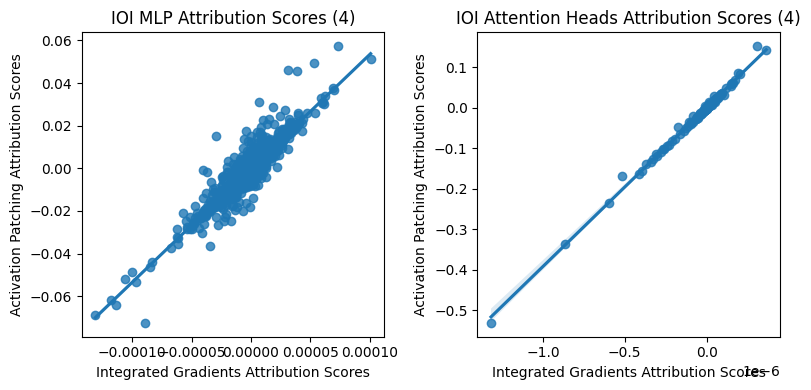

Correlation coefficient for neurons: 0.954893397105745
Correlation coefficient for attention heads: 0.9973041979877735


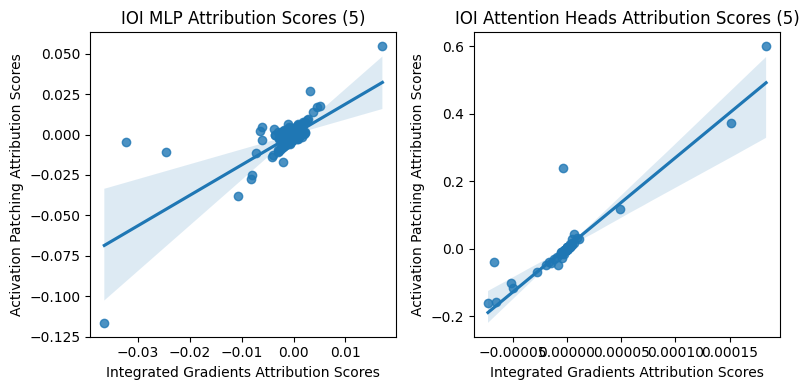

Correlation coefficient for neurons: 0.7371730306227112
Correlation coefficient for attention heads: 0.9243619717710712


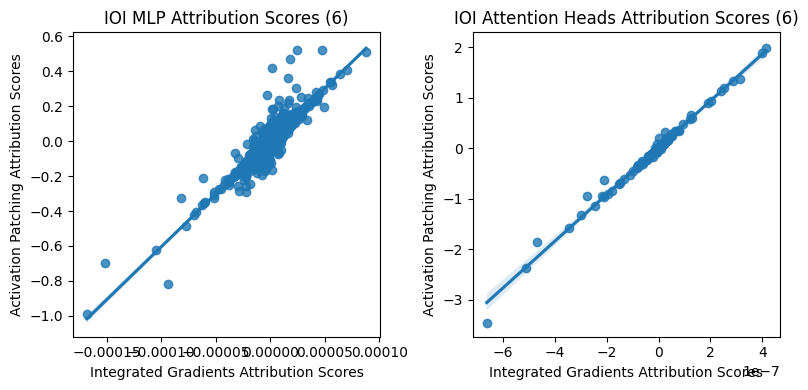

Correlation coefficient for neurons: 0.9515639025371253
Correlation coefficient for attention heads: 0.9939230569388849


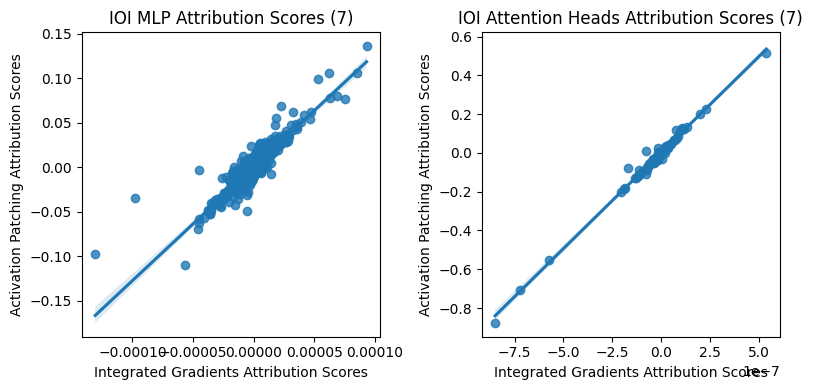

Correlation coefficient for neurons: 0.9485784811942907
Correlation coefficient for attention heads: 0.993869915620021


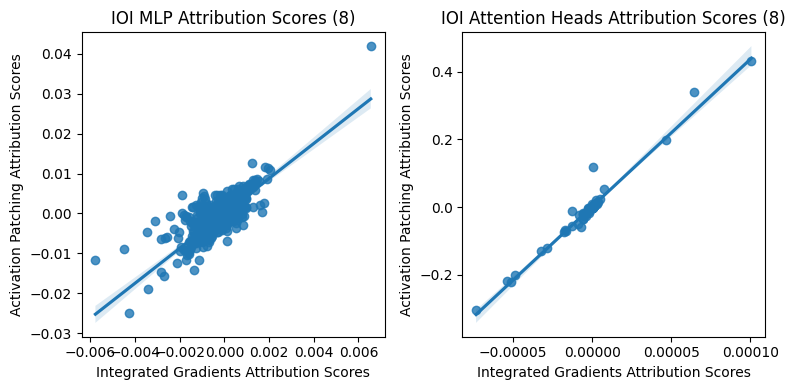

Correlation coefficient for neurons: 0.8262191861389556
Correlation coefficient for attention heads: 0.9833289631996581


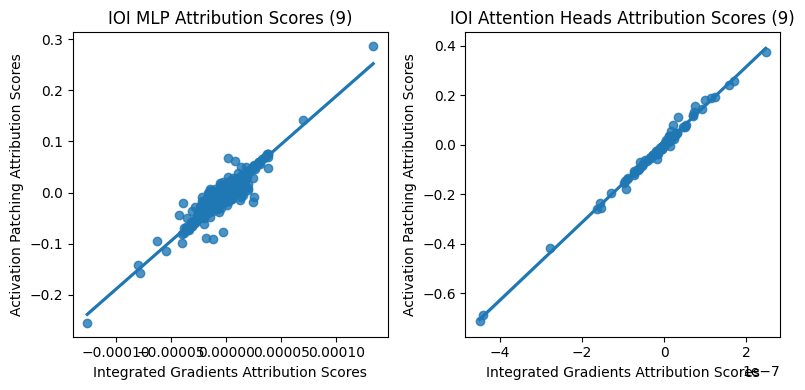

Correlation coefficient for neurons: 0.9621576802607038
Correlation coefficient for attention heads: 0.9963069698120292


In [55]:
plot_attn_comparison(ioi_split_ig_attn, ioi_ap_attn, Task.IOI, model)
plot_correlation(ioi_split_ig_mlp, ioi_ap_mlp, ioi_split_ig_attn, ioi_ap_attn, Task.IOI)